In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:07<00:00, 270MB/s]
100% 1.06G/1.06G [00:07<00:00, 146MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping #helps in reducing overfitting by stoping training when validation peformance stops improving
from keras.applications import MobileNetV2 #experiment with deeper networks,skip connections and pre-trained models
#from keras.regularizers import l2  # For L2 regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator #data augmentation

In [9]:
#generators

# Initialize Data Augmentation for Training Dataset
data_gen = ImageDataGenerator(
    rotation_range=40,           # Random rotation
    width_shift_range=0.2,       # Random horizontal shift
    height_shift_range=0.2,      # Random vertical shift
    shear_range=0.2,             # Shearing transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest',         # Filling strategy
    rescale=1./255               # Normalize pixel values
)

# Apply Data Augmentation to Training Dataset
train_dataset = data_gen.flow_from_directory(
    directory='/content/train',  # Path to the training dataset
    target_size=(256, 256),      # Resize images to 256x256
    batch_size=50,              # Batch size
    class_mode='sparse',         # Sparse integer labels for multi-class classification
    shuffle = 'true'
)

# Load Validation Dataset without Augmentation
validation_dataset = keras.utils.image_dataset_from_directory(
    directory='/content/test',   # Path to the validation dataset
    labels='inferred',           # Infer labels from subdirectory structure
    label_mode='int',            # Integer labels
    batch_size=50,              # Batch size
    image_size=(256, 256)        # Resize images to 256x256
)

Found 20000 images belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [10]:
#images stored in the form of numpy and every numpy value belongs to 0 to 255 but here we have to normalize it from 0 to 1
# Normalize the validation dataset
def process(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

validation_dataset = validation_dataset.map(process)


In [11]:
#create CNN models

# Initialize MobileNetV2 base model
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Initialize the model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))

# Flatten the output from MobileNetV2
model.add(Flatten())

# Add dense layers with L2 regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

<ipython-input-11-d51828ff4ddd>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


In [12]:
# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs = 10, validation_data = validation_dataset)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 352s 830ms/step - accuracy: 0.5379 - loss: 2.8935 - val_accuracy: 0.5510 - val_loss: 0.7248
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 331s 815ms/step - accuracy: 0.5895 - loss: 0.6823 - val_accuracy: 0.6594 - val_loss: 0.6031
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 335s 822ms/step - accuracy: 0.6371 - loss: 0.6315 - val_accuracy: 0.6242 - val_loss: 0.6459
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 331s 812ms/step - accuracy: 0.6654 - loss: 0.6039 - val_accuracy: 0.6760 - val_loss: 0.6936
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 332s 818ms/step - accuracy: 0.6924 - loss: 0.5775 - val_accuracy: 0.7320 - val_loss: 0.5538
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 380s 813ms/step - accuracy: 0.7099 - loss: 0.5632 - val_accuracy: 0.7358 - val_loss: 0.5224
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 382s 812ms/step - accuracy: 0.7210 - loss: 0.5427 - val_accuracy: 0.7454 - val_loss: 0.5123
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 335s 821ms/step - accuracy: 0.7379 - loss: 0.52

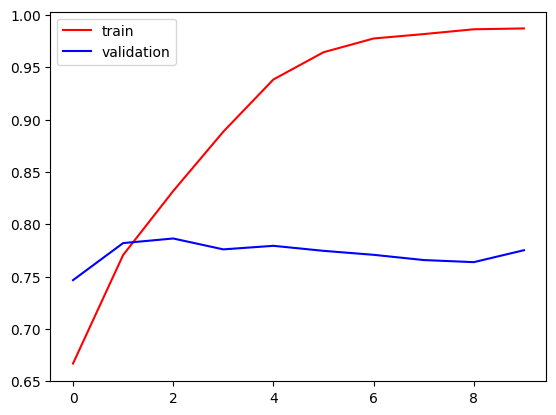

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.ylim(0.65, None)
plt.legend()
plt.show()

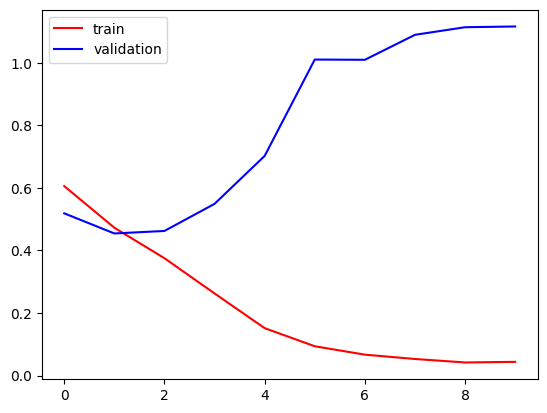

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [33]:
#This model is giving better results on training data but not on test/validation data. The gap between the lines clearly shows overfitting. So we have to reduce it.

#ways to reduce overfitting

#add more data
#data augmentation
#L1/L2 regularizer
#Dropout
#batch Norm
#reduce complexity

# so we are adding BatchNormalization, Dropout, L2 regularizer here.We are modifying this in above stuffs and below graph corresponds to these changes.
# we have also used MobileNetV2 and earlystopping. MobileNetV2 increase computational efficiency and earlystopping reduce the time by halting the training if there is no progress in val_loss

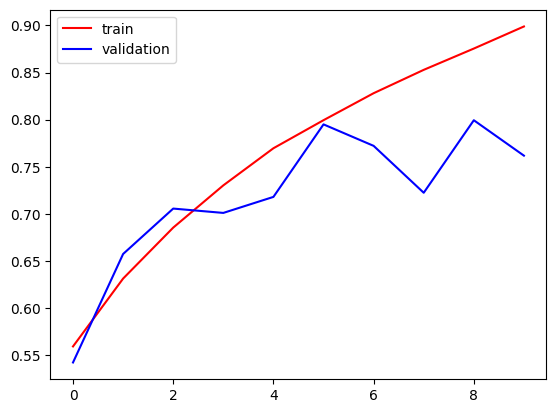

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

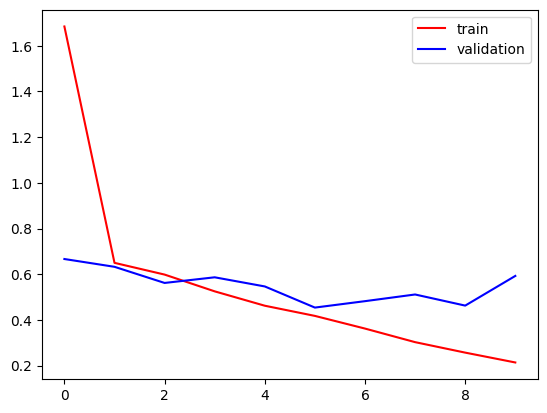

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()


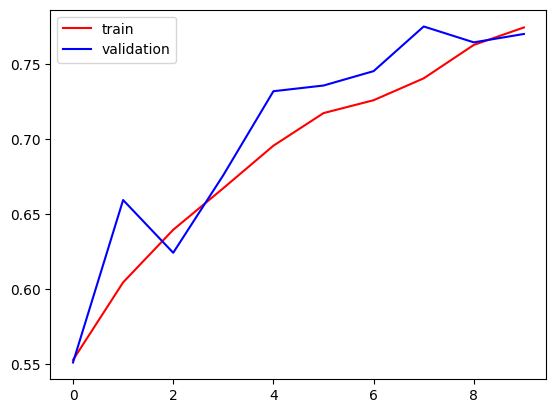

In [25]:
#here i am not using L2 regularizer as above because it is leading to underfitting
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

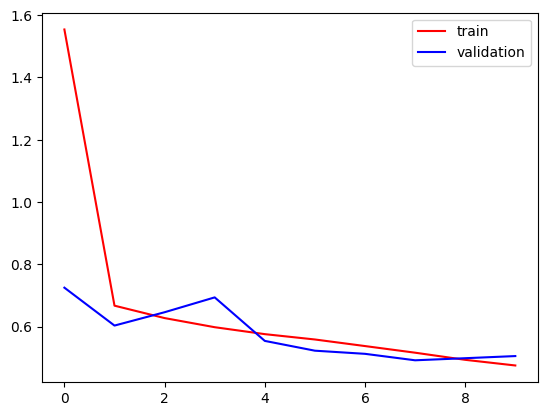

In [15]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [16]:
import cv2

In [18]:
test_img = cv2.imread('/content/cat.jpg')

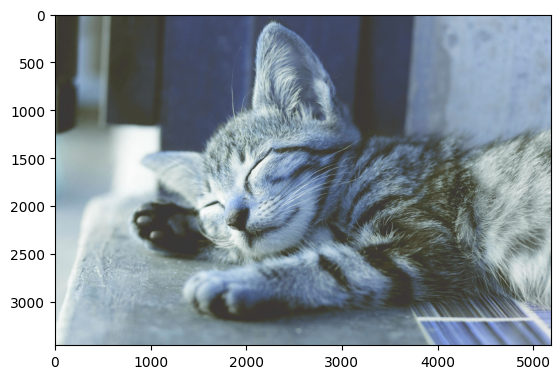

In [19]:
plt.imshow(test_img)

In [21]:
test_img.shape

(3456, 5184, 3)

In [22]:
test_img = cv2.resize(test_img, (256, 256))

In [23]:
test_input = test_img.reshape(1, 256, 256, 3) # converting in 4 dimensions where 1st element is represting no. of picture in the batch which is 1 in this case

In [24]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.]], dtype=float32)

In [26]:
test_image = cv2.imread('/content/dog.jpg')

In [27]:
test_image.shape

(3840, 5760, 3)

In [28]:
test_image = cv2.resize(test_image, (256, 256))

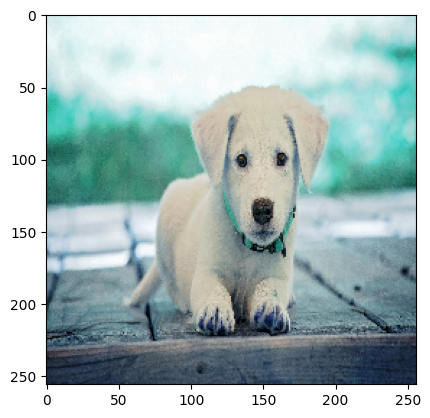

In [29]:
plt.imshow(test_image)

In [30]:
test_ipt = test_image.reshape(1, 256, 256, 3)

In [31]:
model.predict(test_ipt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[1.]], dtype=float32)

In [32]:
#0 for cat and 1 for dog